In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


import celloracle as co
co.__version__

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


'0.10.14'

In [2]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

In [3]:
oracle = co.load_hdf5('/home/jovyan/jm_jlab/data_indNeuro/1.GRN/tr21_pcw16.celloracle.oracle')

In [4]:
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.10.14
    n_cells: 2164
    n_genes: 4000
    cluster_name: milestones
    dimensional_reduction_name: X_pca
    n_target_genes_in_TFdict: 18193 genes
    n_regulatory_in_TFdict: 399 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 83 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 3557 genes
    k_for_knn_imputation: 54
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

In [5]:
links = co.load_hdf5('/home/jovyan/jm_jlab/data_indNeuro/1.GRN/milestones_pcw16_baggindridge.celloracle.links')

In [7]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

  0%|          | 0/4 [00:00<?, ?it/s]

## In silico perturbation 

In [11]:
goi = "KLF6"

In [10]:
'EOMES' in oracle.adata.var[oracle.adata.var['isin_TFdict_targets'] == True].index

True

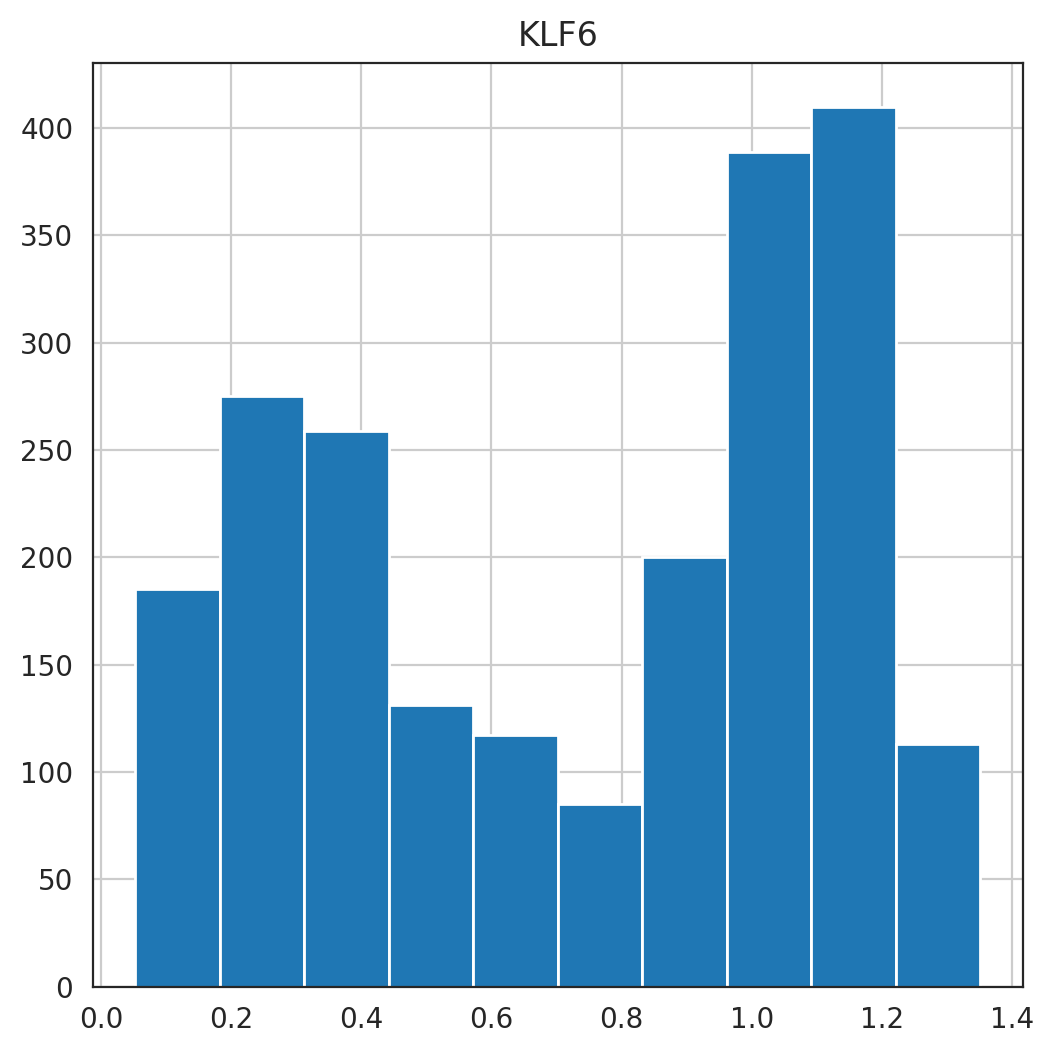

In [9]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [12]:
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [13]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

### Optimal scale parameter

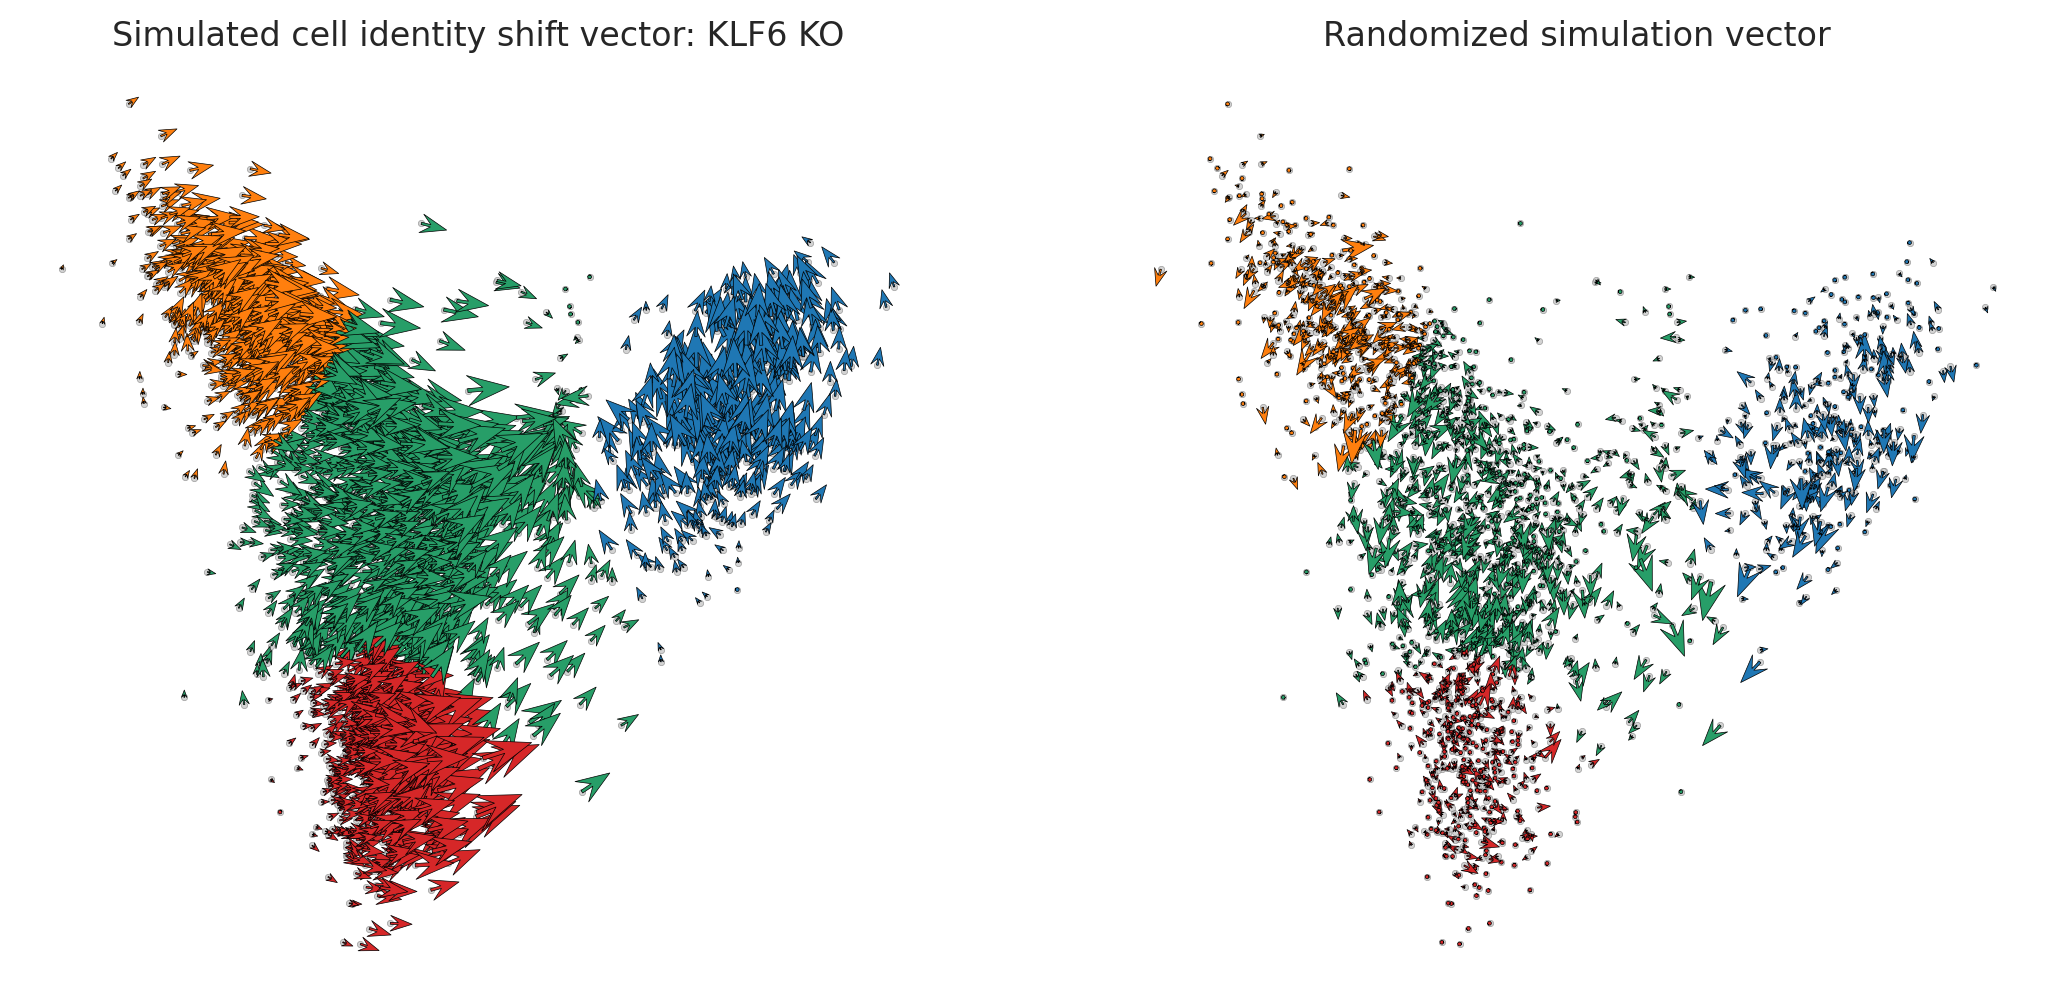

In [14]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()


In [15]:
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

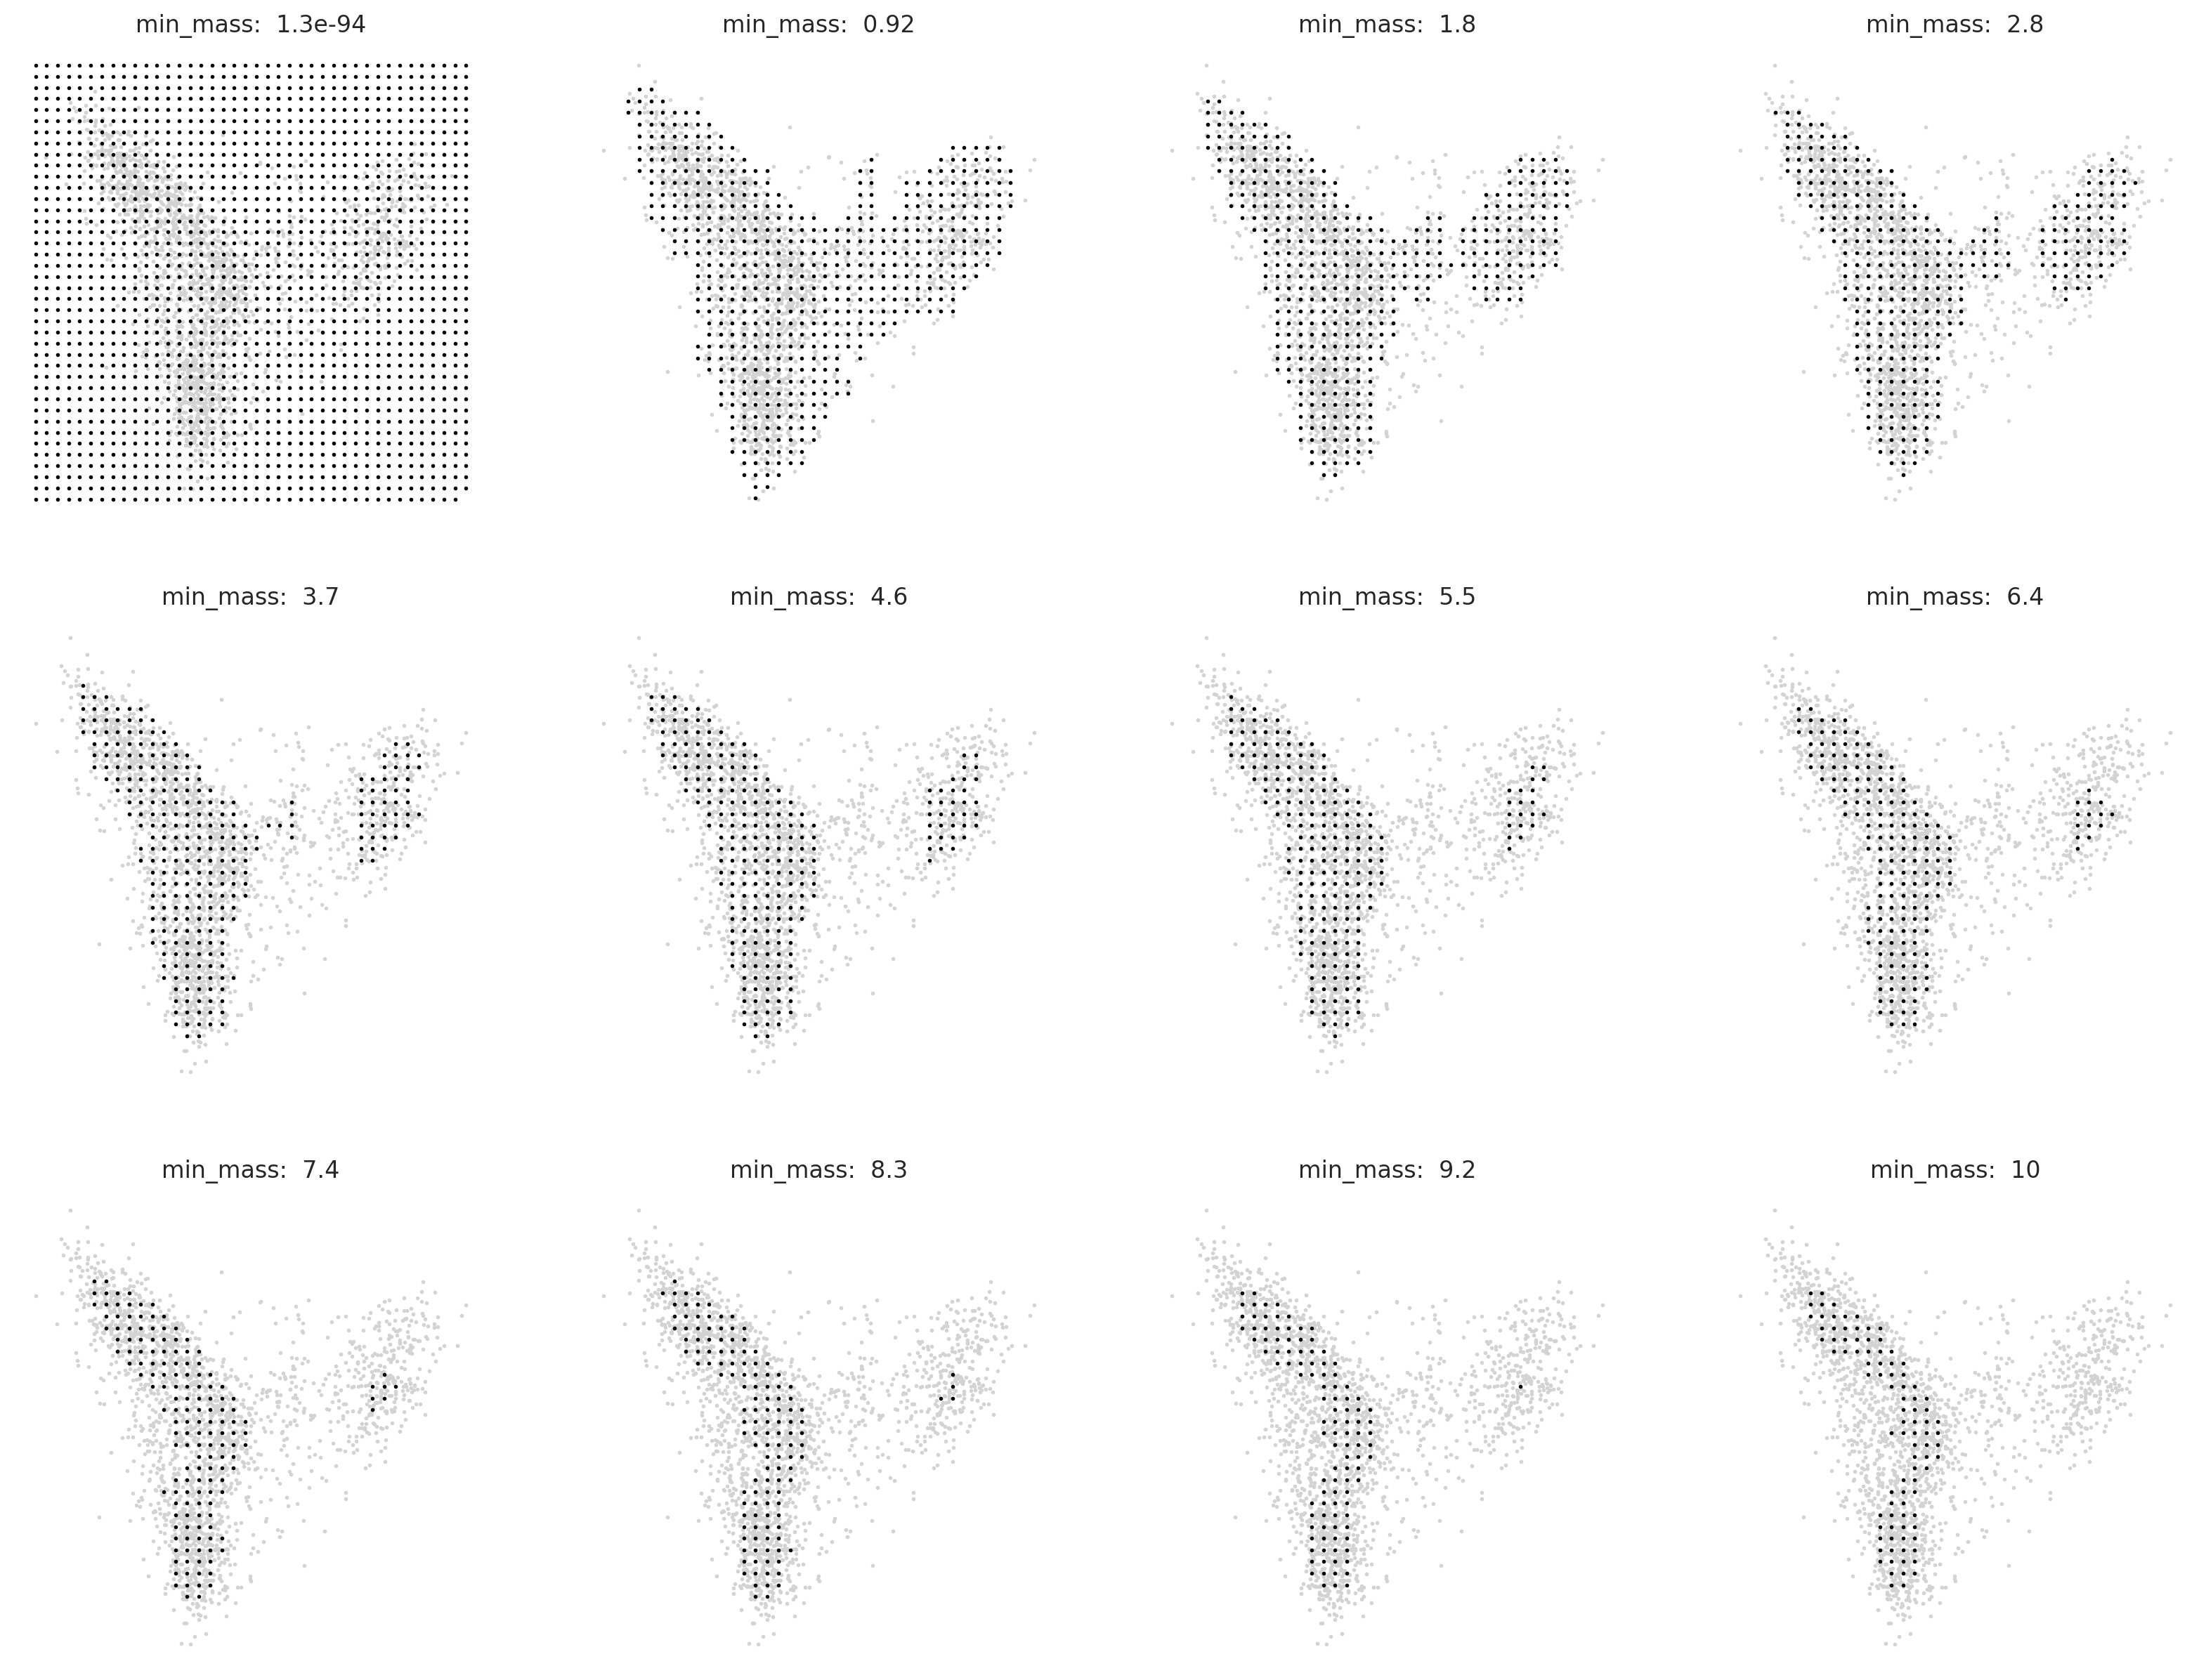

In [16]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

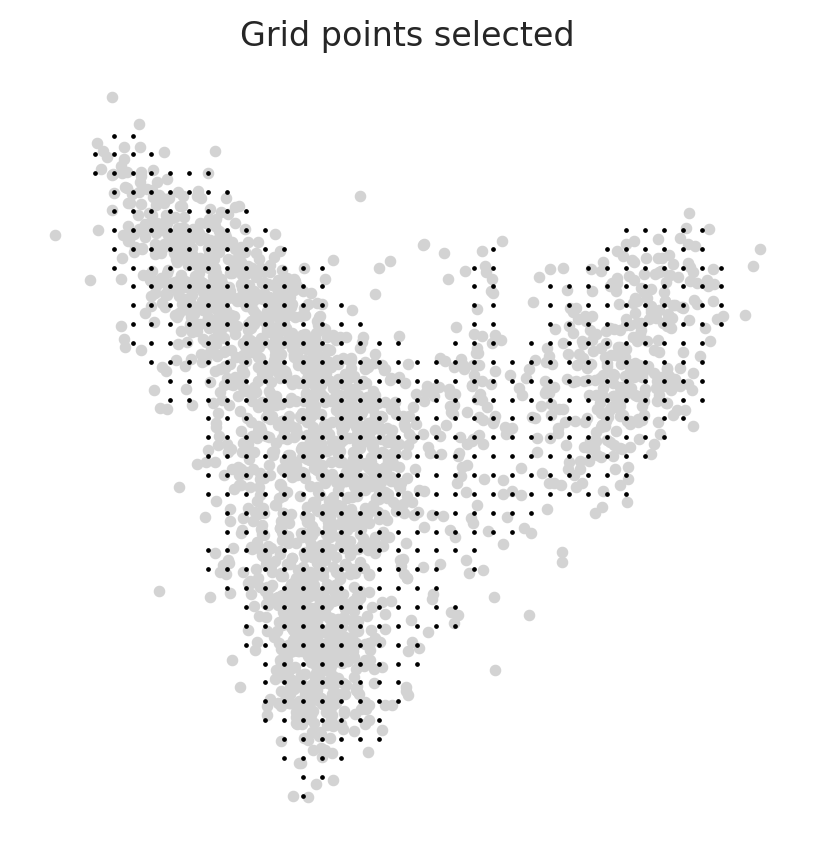

In [17]:
min_mass = 0.92
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

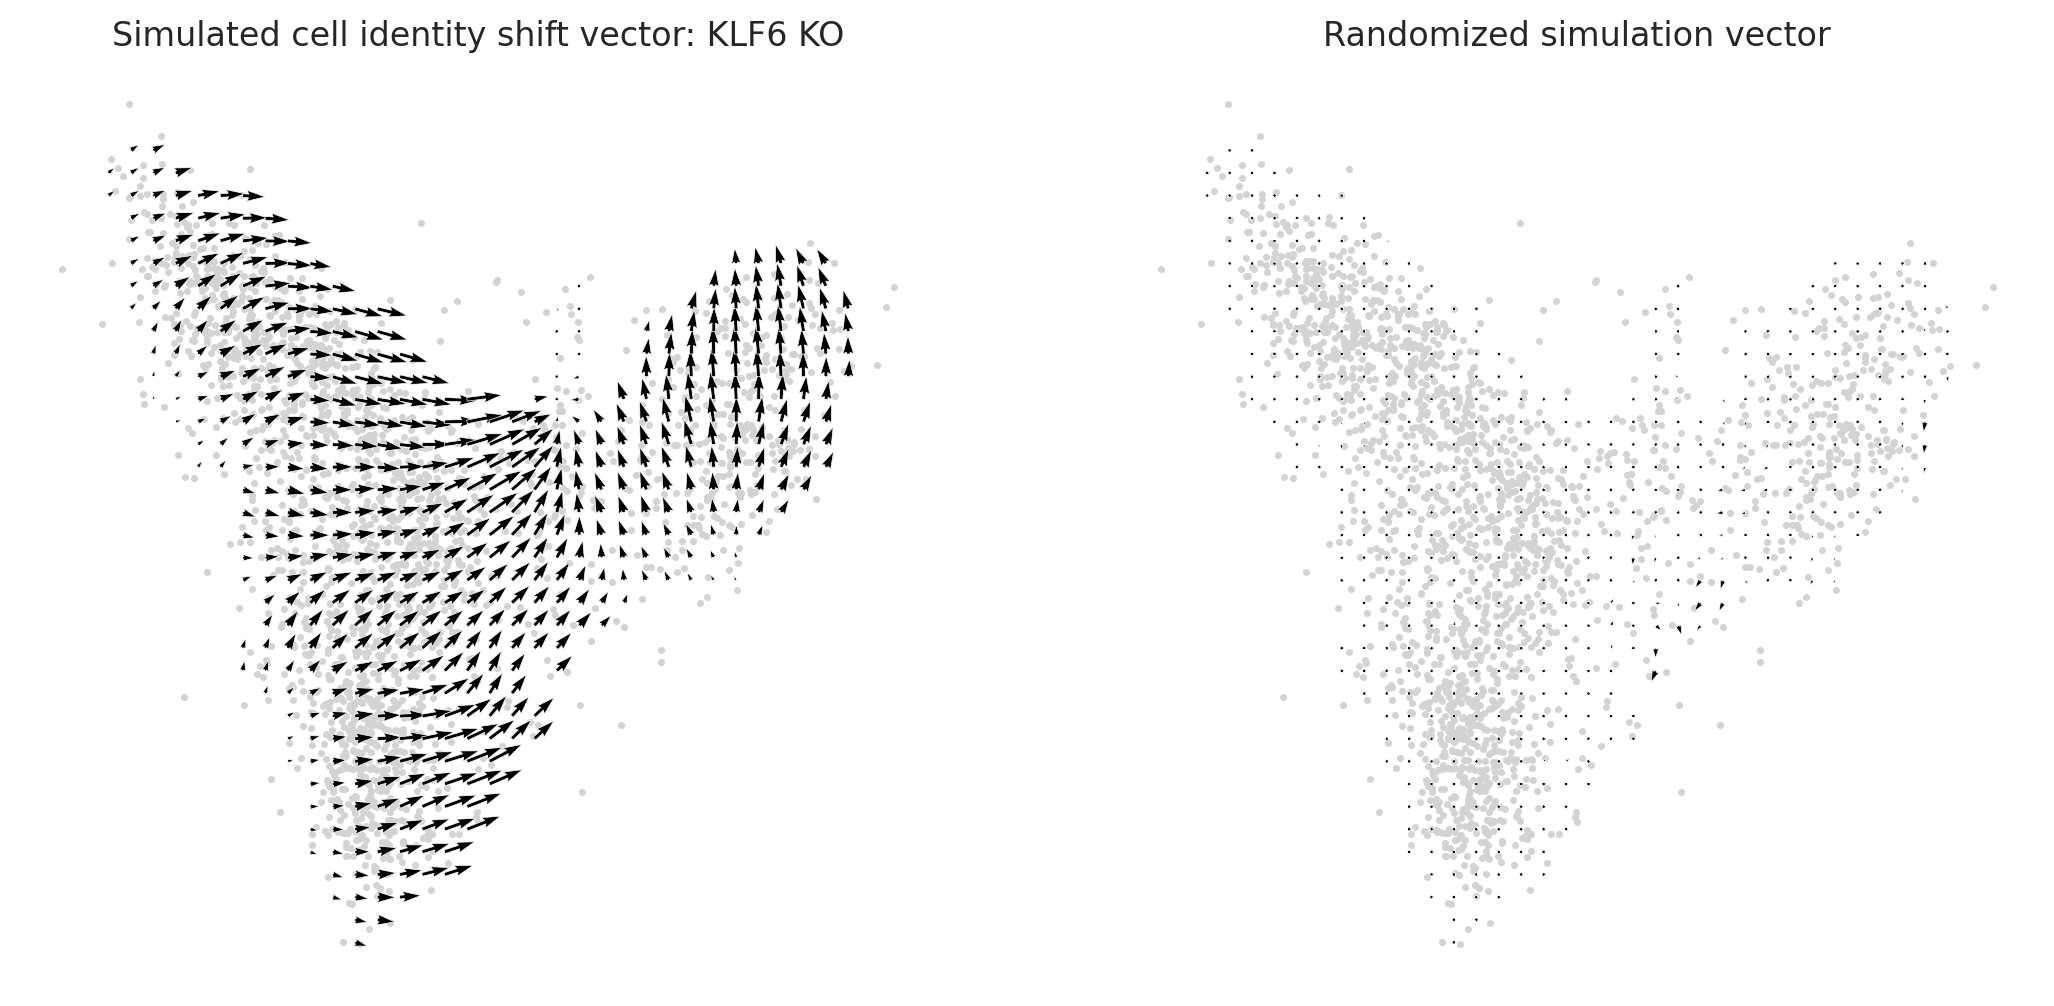

In [18]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 30
# Show quiver 20
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

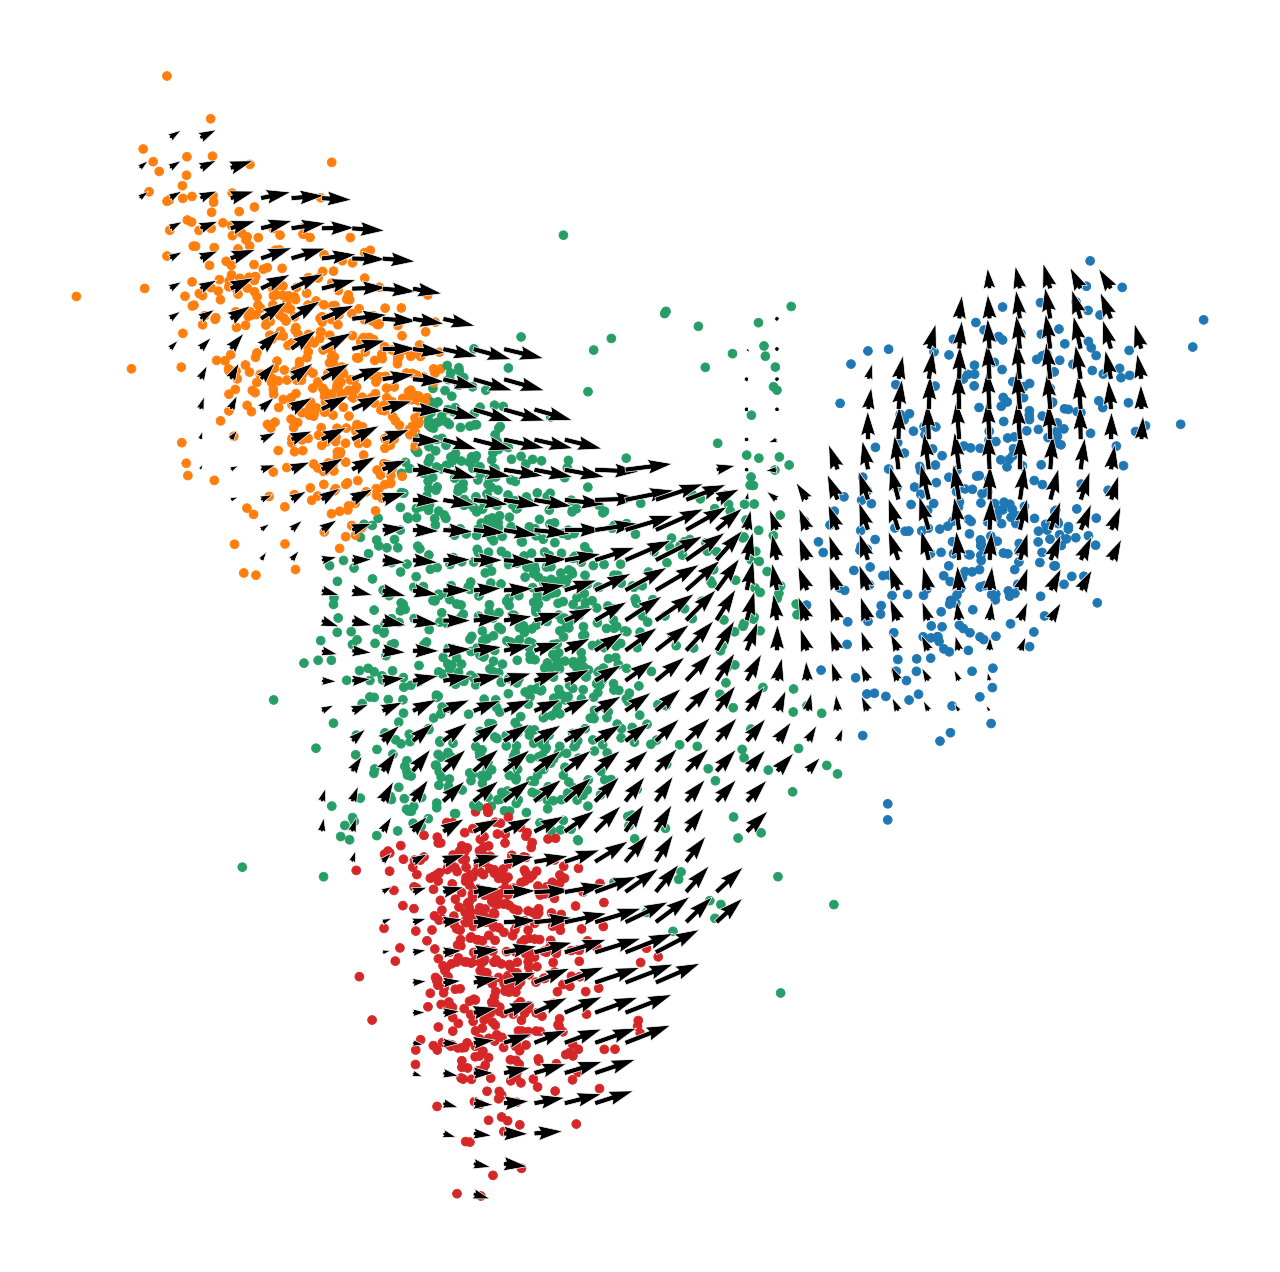

In [19]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

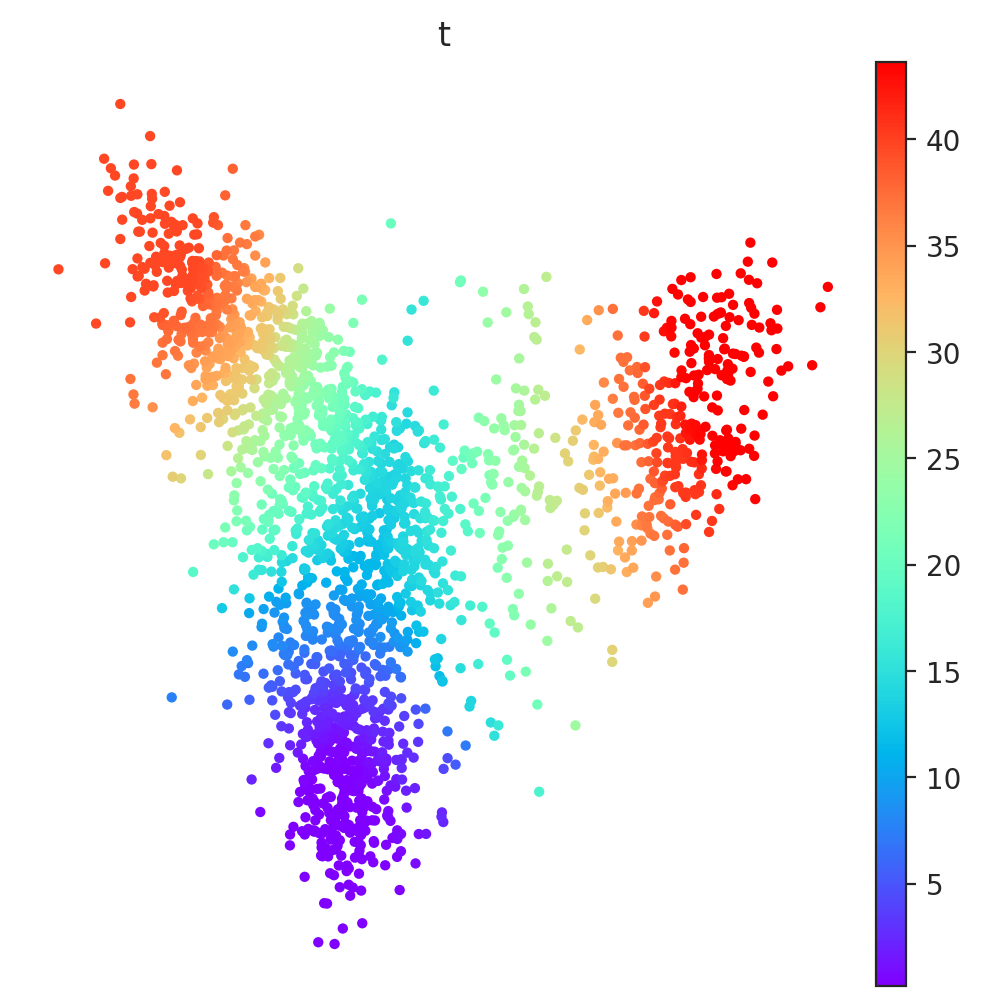

In [27]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=["t"], frameon=False)

In [28]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="t")

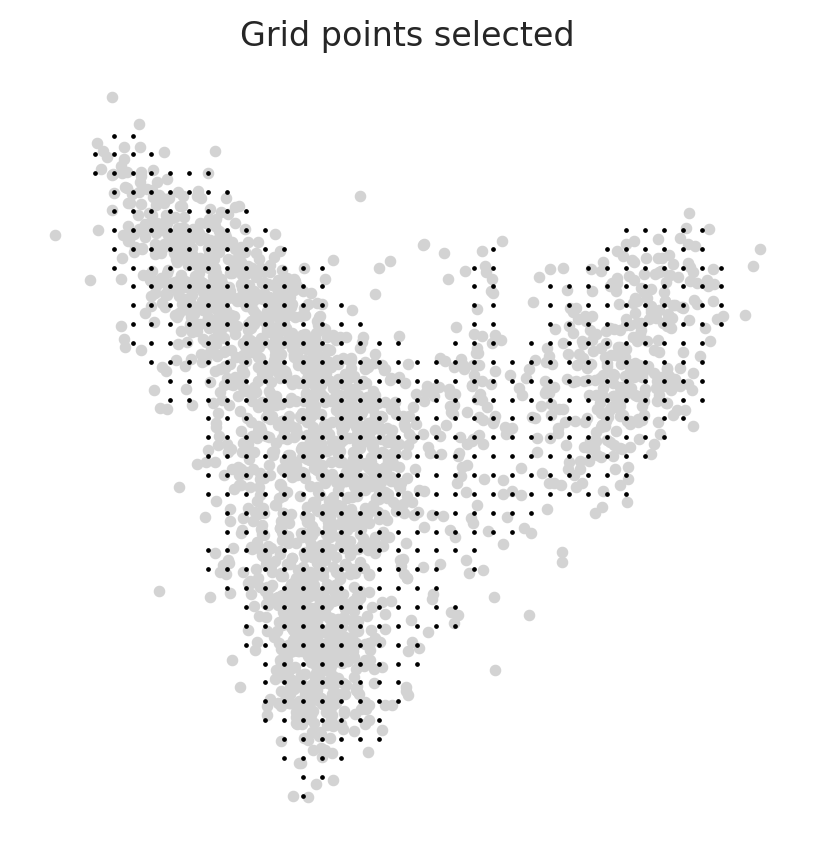

In [29]:
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

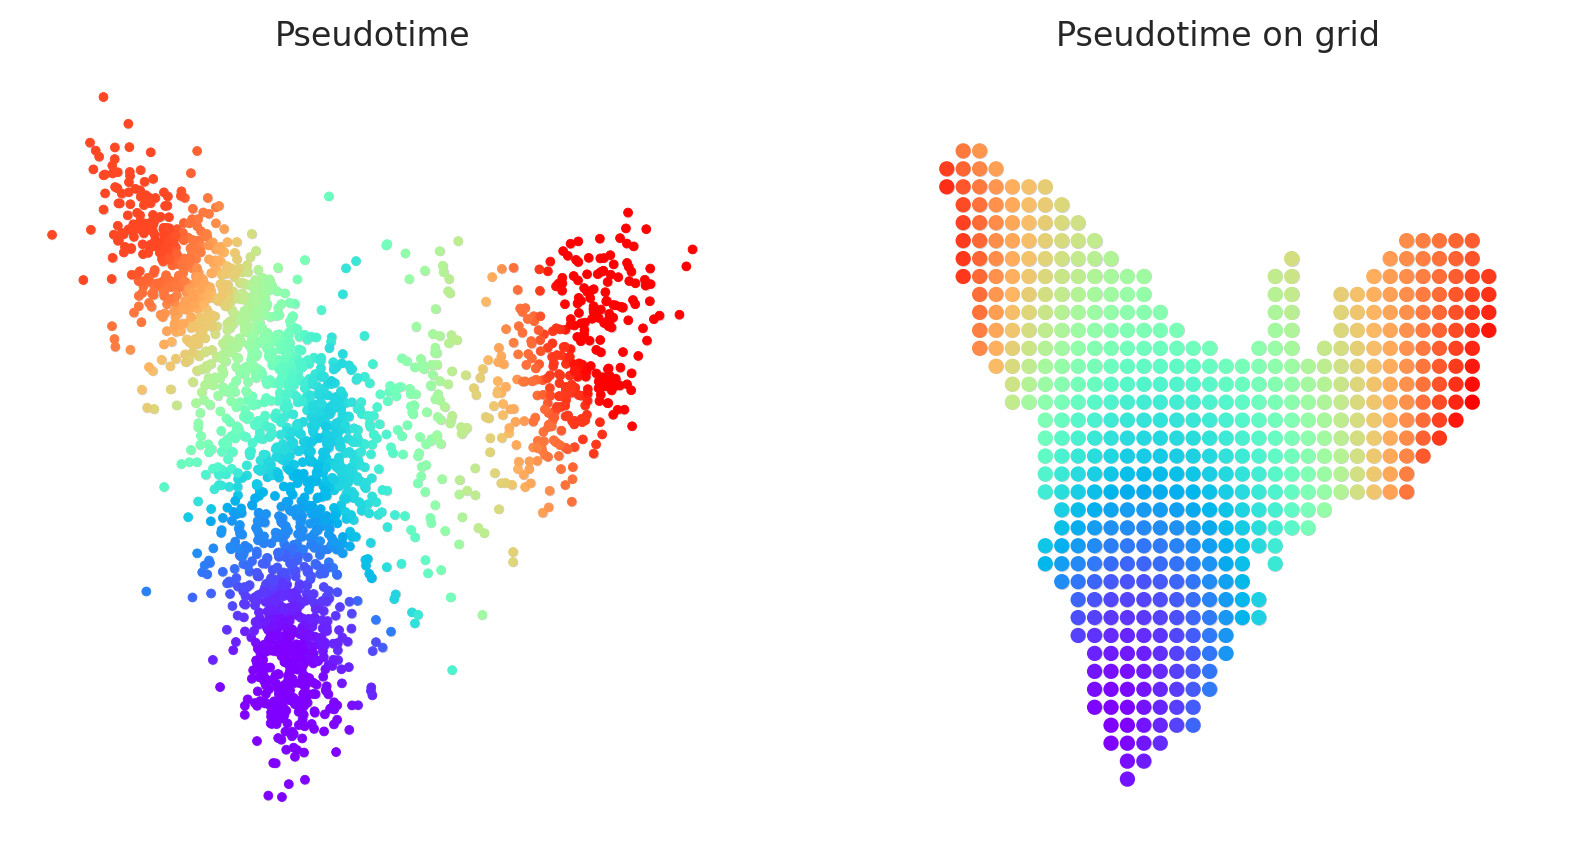

In [30]:
gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3}, plot=True)

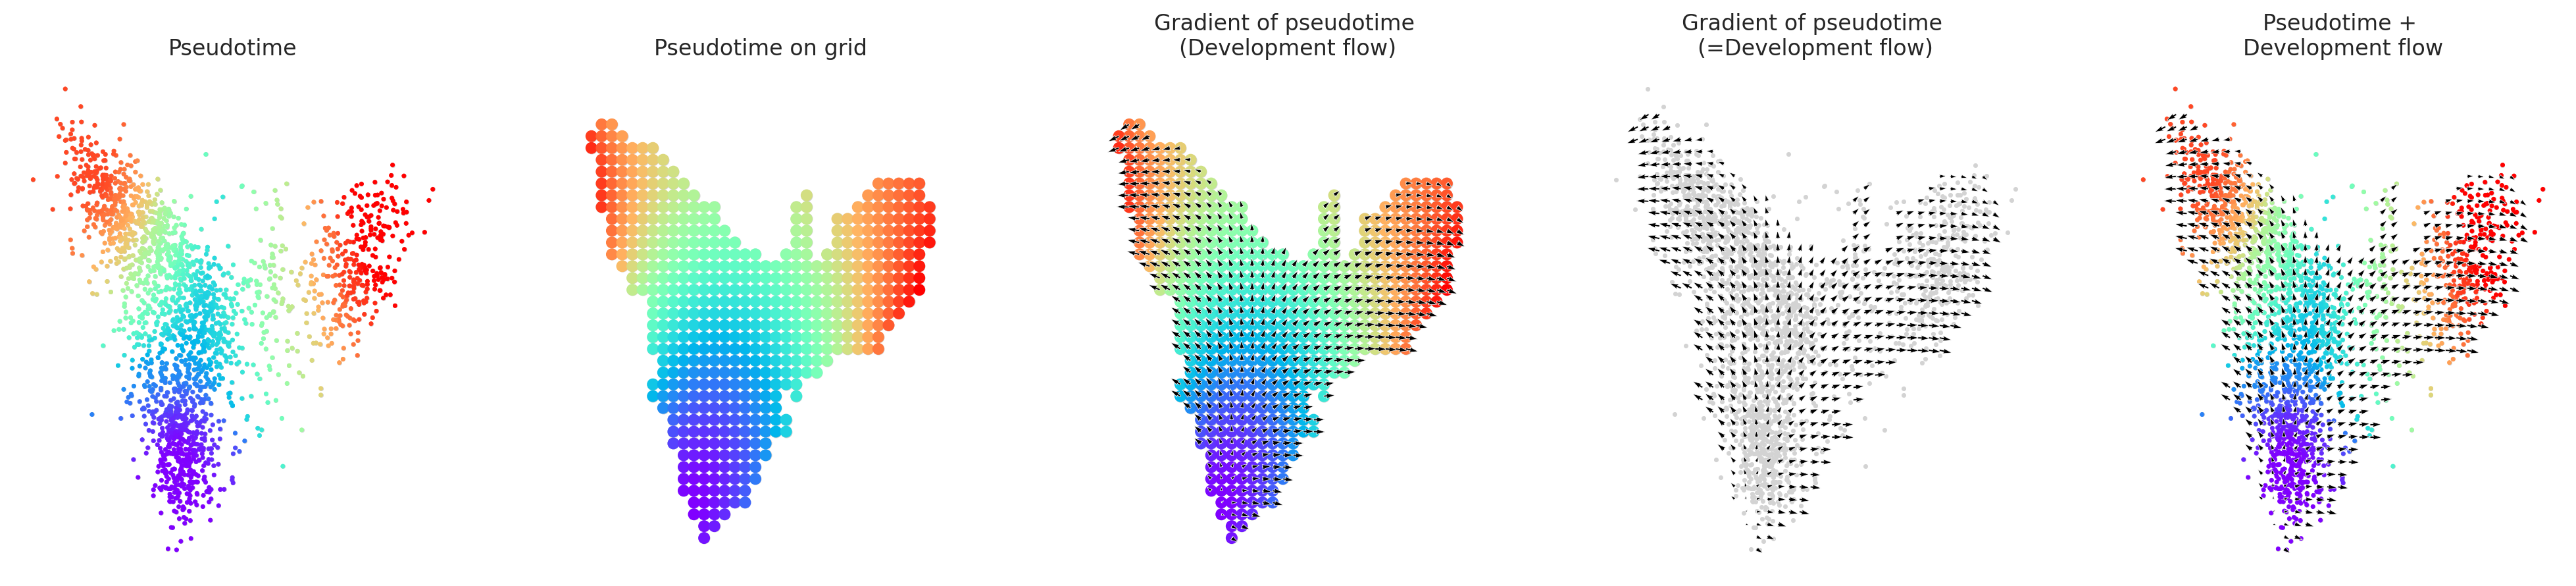

In [31]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

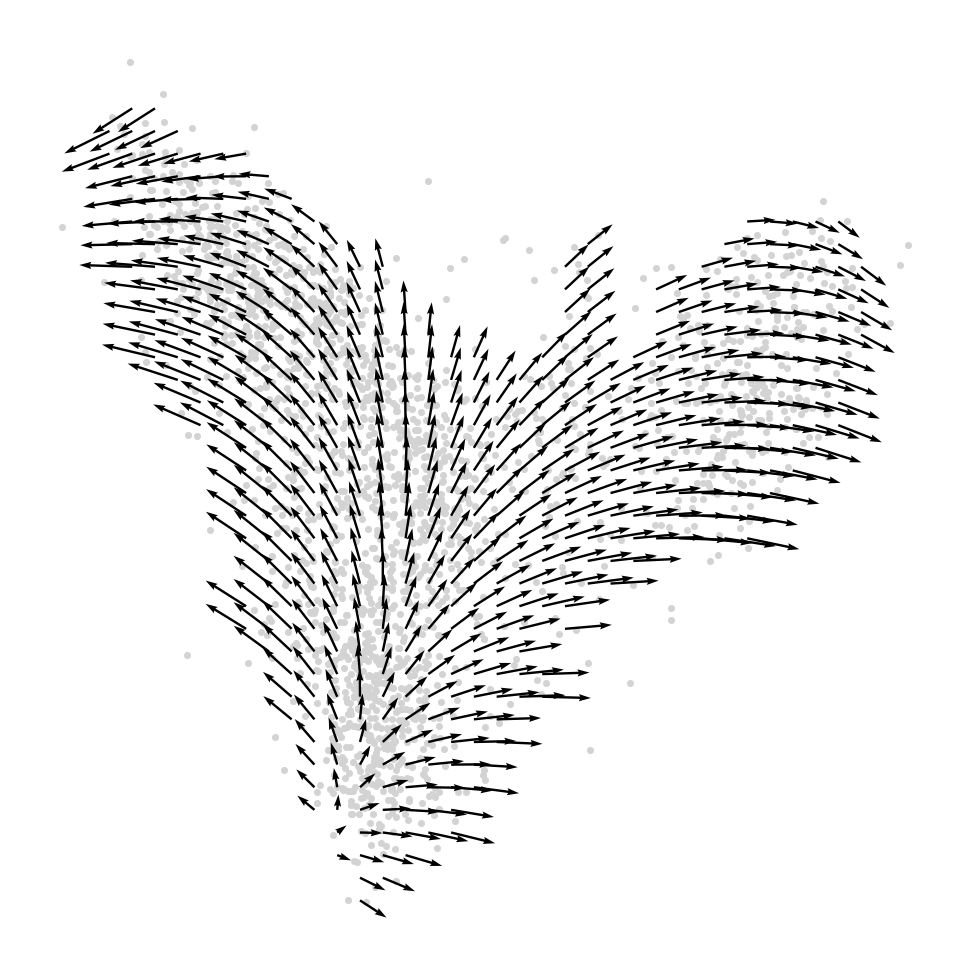

In [42]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=20, ax=ax)

In [35]:
from celloracle.applications import Oracle_development_module

# Make Oracle_development_module to compare two vector field
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)


# Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

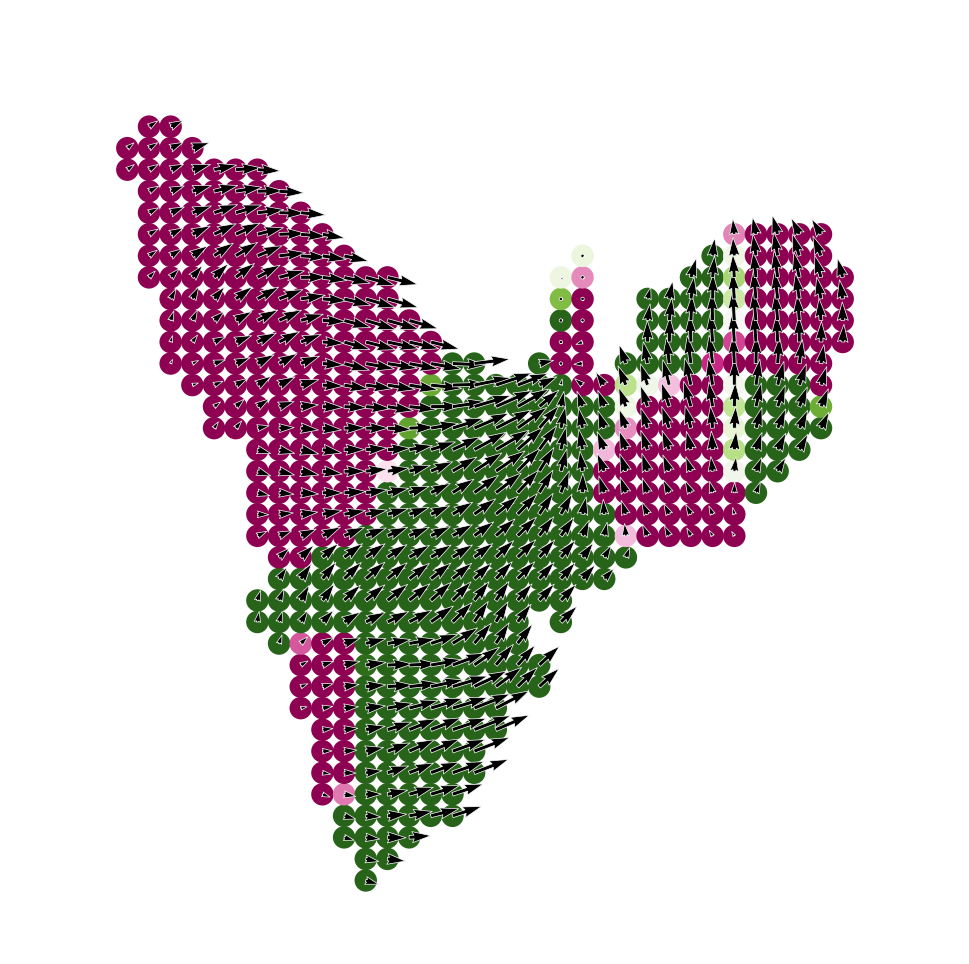

In [37]:
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)
